# Problem Solving for Chemical Engineers
### *Jacob Albrecht*, https://app.dominodatalab.com/u/jakealbrecht/ChE_problemSolving

This notebook works through example chemical engineering problems from http://www.polymath-software.com/index.htm, using the Python programming language. The examples entail some of the publicly available solutions to select problems from the textbook "Problem Solving in Chemical and Biochemical Engineering with POLYMATH, Excel and MATLAB" by Michael B. Cutlip and Mordechai Shacham.  The goal of this workbook is to show the accessibility and power of a pair of modern software tools:  Jupyter notebooks and scientific Python.


## What is a Jupyter notebook?
This page is a Jupyter notebook: a web-based noteboo that consists of a single column of  cells that can contain computer code (that runs on the server in the background).  The notebook cells can contain formatted text, images, even $\LaTeX$!  Double-clicking on any cell will enable its contents to be edited.  Because the notebook is running as a web page, everything is taken care of on the server side; there is no software to install for the end user.  Notebooks can also be easily converted to read-only formats such as non-interactive web pages or PDFs.  


## Why Python?
Python is the programming language that runs in the background of this particular notebook.  Python is a very powerful, but easy to learn programming language that is used for a wide variety of applications including scientific problem solving.  To get started, we must import some of the scientific functionality in the code cell below.  When using python for scientific or engineering applications, typical libraries include `numpy`, `scipy`, and `pandas` for functionality and the `matplotlib` or `seaborn` libraries for plotting.  This notebook includes an example using `sympy`, the powerful symbolic math library.  Libraries can loaded using the `import` command, typically at the beginning of a notebook.  Here is the python code below:


In [1]:
# these statements load libraries :
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt

# set font to use for plotting (optional)
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'  

#tell the notebook to show plots will cell outputs
%matplotlib inline  

Next, for posterity print out the versions of the libraries used:


In [2]:
%load_ext version_information
%version_information pandas, numpy, scipy, matplotlib

Software versions
Python 3.5.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.3.0
OS Linux 3.13.0 123 generic x86_64 with debian jessie sid
pandas 0.20.1
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.2
Sun Aug 13 18:39:25 2017 UTC

Ok, lets get started on some problems!

## Molar Volume and Compressibility factor from Van Der Waals Equation  (Problem 1-1a)

Goal: Find the value of $V$ that sets the value of the objective function closest to zero

$$f=\left(P+\frac{a}{V^2}\right)\left(V-b\right)-RT$$

Where:

$$a=\frac{27}{64}\frac{R^2T_c^2}{P_c}$$


$$b=\frac{R T_c}{8P_c}$$

For this problem, reduced pressure $P_r$ is set at 0.5.  

First, define the constants and the objective function to minimize:

In [3]:
def fun1_1(V):
    P = 56
    R = 0.08206
    T = 450
    Tc = 405.5
    Pc = 111.3
    a = 27*(R**2*Tc**2/Pc)/64
    b = R*Tc/(8*Pc)
    f = (P+a/(V**2))*(V-b)-R*T
    return(f)

Next, use `fsolve` to find the value of $V$ that satisfies the equation and mimimizes the objective function

In [4]:
Vguess=0.5
Vsolv=fsolve(fun1_1,Vguess) #Use fsolve  to solve the equation/s
pd.DataFrame({'V':[Vguess,Vsolv[0]],
              'Objective Function':[fun1_1(Vguess),fun1_1(Vsolv[0])]},
             index=['Initial','Final'])

,Objective Function,V
Initial,-3.253276,0.500000
Final,0.000000,0.574892


Solution: the optimal value of $V$ is about 0.575

## Molar Volume and Compressibility factor from Van Der Waals Equation for *different* reduced pressures (Problem 1-1b)

Like problem 1-1a, but now solve for a range of reduced pressures ($P_r$=1, 2, 4, 10, 20) 

Use the objective function from previous, but include the relationship between pressure $P$, reduced pressure $P_r$, and critical pressure $P_c$:

$$ P = P_cP_r$$

In [5]:
def fun1_1b(x):
    V=x
    R = 0.08206
    T = 450
    Tc = 405.5
    Pc = 111.3
    P = Pc*Pr
    a = 27*(R**2*Tc**2/Pc)/64
    b = R*Tc/(8*Pc)
    Z = P*V/(R*T)
    f = (P+a/(V**2))*(V-b)-R*T
    return(f)

Define the range of $P_r$ to examine, then perform `fsolve` in a loop for each case:

In [6]:
Pr_set = [1,2,4,10,20] # range of Pr's to examine
from collections import defaultdict
xsolv = 0.5
results = [] # initialize results to be empty
for Pr in Pr_set:    
    xguess = xsolv  # set initial guess to be previous solution
    xsolv=fsolve(fun1_1b,xguess)[0] #Use fsolve  to solve the equation/s
    results.append({'Initial Objective Function':fun1_1b(xguess),
                    'Initial V':xguess,
                    'Final Objective Function':fun1_1b(xsolv),
                    'Final V':xsolv,'Pr':Pr})

pd.DataFrame(results).sort_index(axis=1,ascending=False) # print out a table of all results

,Pr,Initial V,Initial Objective Function,Final V,Final Objective Function
0,1,0.500000,22.330096,0.233509,-7.105427e-15
1,2,0.233509,21.830094,0.077268,-2.842171e-14
2,4,0.077268,8.880926,0.060654,0.000000e+00
3,10,0.060654,15.548432,0.050875,1.421085e-14
4,20,0.050875,15.030021,0.046175,6.394885e-13


From the table of results, the final value of $V$ from the optimization decreases with increasing $Pr$

## Fitting Polynomials and Correlation Equations to Vapor Pressure Data - Polynomials (Problem 1-3a)

In this problem we use a set of experimental vapor pressure data to create a predictive model for the vapor pressure of Benzene as a function of temperature.  This section creates polynomial models of the form:

$$P_{vap}= \sum_{i=0}^n{\beta_iT^i}$$

Where $\beta$ are regressed coefficients and $n$ is the degree of the polynomial.  For example an degree 2 polynomial would have the form:  

$$P_{vap}=\beta_2T^2+\beta_1T+\beta_0$$

To start, first download the data file from http://www.polymath-software.com, using the linux `curl` command

In [7]:
!curl http://www.polymath-software.com/WorkedProblems/Chapter%201/Matlab/P1-3a/pro1_3.dat -o pro1_3.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    92  100    92    0     0    617      0 --:--:-- --:--:-- --:--:--  1260


Inspect the data:

In [8]:
# Load vapor pressure data T in deg. C and P in mmHg
pro1_3 = pd.read_csv('pro1_3.dat',header=None,delimiter='\t') 
xyData = pd.DataFrame({'Temperature':pro1_3[0]+273.15,
                       'Vapor Pressure (mm Hg)':pro1_3[1]})
min_degree = 1; # minimal degree of a polynomial 
max_degree = 5; # maximal degree of a polynomial 
xyData

,Temperature,Vapor Pressure (mm Hg)
0,236.45,1
1,253.55,5
2,261.65,10
3,270.55,20
4,280.75,40
5,288.55,60
6,299.25,100
7,315.35,200
8,333.75,400
9,353.25,760


For the parameter confidence interval ranges, we will us the t distribution, imported from `scipy`:

In [9]:
from scipy.stats.distributions import t
alpha = 0.05 # for 95% confidence intervals

Try several polynomial fits for degree between 1 and 5: 

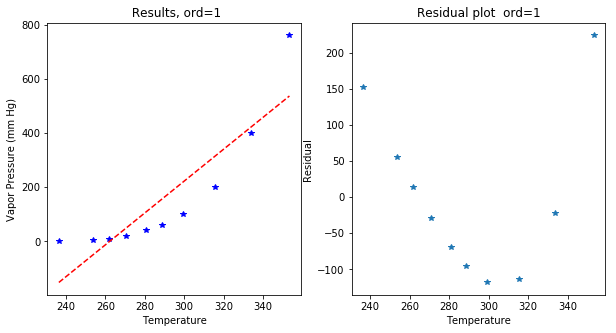

Degree 1, Residual variance: 14823.82

          Beta      CI +/-
1     5.890720    2.946769
0 -1544.644084  858.671783


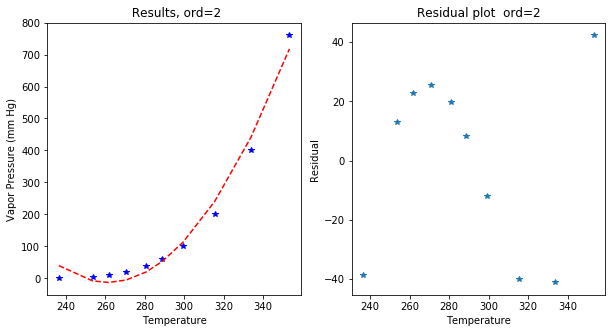

Degree 2, Residual variance: 1216.79

          Beta       CI +/-
2     0.086153     0.025343
1   -44.998001    14.995996
0  5862.699245  2194.268049


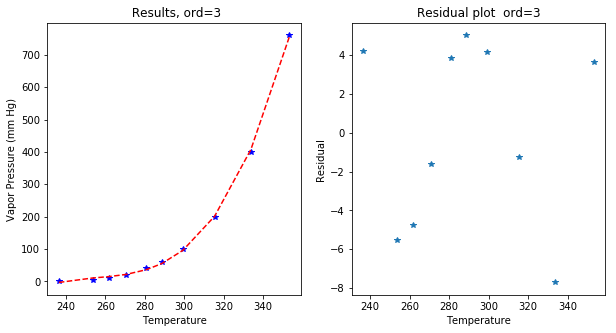

Degree 3, Residual variance: 34.12

           Beta       CI +/-
3      0.000745     0.000143
2     -0.570969     0.126252
1    146.383159    36.844240
0 -12540.815474  3555.398287


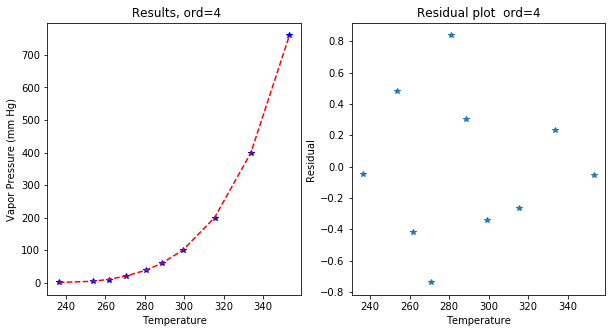

Degree 4, Residual variance: 0.40

           Beta        CI +/-
4      0.000004  5.826671e-07
3     -0.003917  6.856155e-04
2      1.471676  3.006917e-01
1   -248.690044  5.825103e+01
0  15917.848176  4.205576e+03


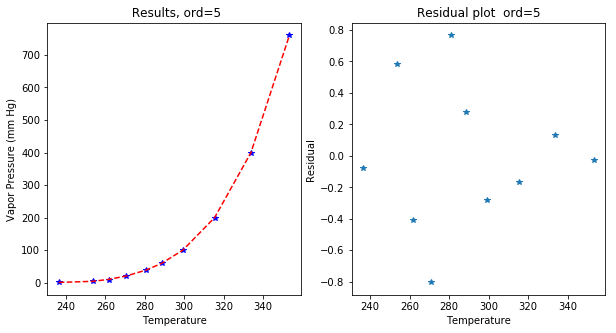

Degree 5, Residual variance: 0.49

           Beta        CI +/-
5 -2.505100e-09  3.197484e-08
4  7.647407e-06  4.703168e-05
3 -6.073500e-03  2.753977e-02
2  2.099593e+00  8.024305e+00
1 -3.396394e+02  1.163365e+03
0  2.116011e+04  6.713730e+04


In [10]:
x_name='Temperature'
y_name='Vapor Pressure (mm Hg)'
for degree in range(min_degree,max_degree+1):
    x=xyData[x_name].values
    y=xyData[y_name].values
    fit, cov = np.polyfit(x,y,
                          degree,
                          full=False, cov= True)
    Yfit = np.poly1d(fit)
    residuals = y-Yfit(x)
    dof = xyData.shape[0]-fit.shape[0]
    tval = t.ppf(1-alpha/2,dof)
    sigma = np.sqrt(np.diag(cov))
    variance=np.dot(residuals.T,residuals)/dof
    results = pd.DataFrame({'Beta':fit,
                            'CI +/-':sigma*tval},
                           index=list(reversed(range(len(fit)))))
    
    plt.figure(figsize=(10,5))    
    
    plt.subplot(1,2,1)
    plt.title(' Results, ord={}'.format(degree))
    plt.plot(x,y,'b*')
    plt.plot(x,Yfit(x),'r--')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.subplot(1,2,2)    
    plt.title('Residual plot  ord={0}'.format(degree))
    plt.plot(x,residuals,'*')
    plt.xlabel(x_name)
    plt.ylabel('Residual')
    plt.show()
    print('Degree {}, Residual variance: {:3.2f}\n'.format(degree,variance))
    print(results)
      

From the fits and residuals, the degree 4 polynomial provides the best fit to the data.

## Fit the Vapor Pressure vs. Temperature data to the Clapeyron equation (Problem 1-3b)

Fit the Vapor Pressure vs. Temperature data to the Clapeyron equation:

$$P_{vap}=\exp\left(\beta_0+\frac{\beta_1}{T}\right)$$

This equation is non-linear, so we will use a different fitting function, `scipy`'s `curve_fit` 

In [11]:
from scipy.optimize import curve_fit

A custom function is also needed to describe the Clapeyron equation, returning the value of $P_{vap}$ given $T$, $\beta_0$ and $\beta_1$:

In [12]:
def clapeyron(T,B0,B1):
    Pvap = np.exp(B0+B1/T)
    return(Pvap)

Do the fitting:

In [13]:
x_name='Temperature'
y_name='Vapor Pressure (mm Hg)'
x=xyData[x_name].values
y=xyData[y_name].values
fit, cov = curve_fit(clapeyron, x,y)

From the fitted results, plot the predictions and print a table of the parameter statistics:


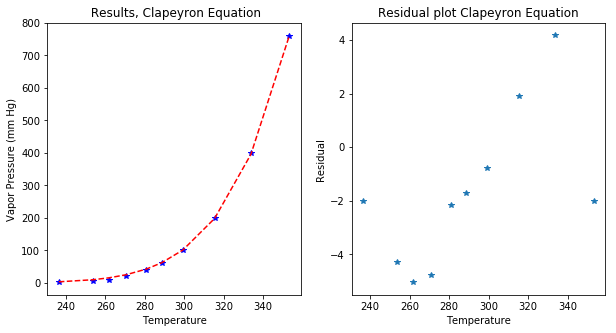

Residual variance: 12.97

          Beta     CI +/-
0    17.846185   0.221936
1 -3960.018499  76.655896


In [14]:
Yfit = clapeyron(x,*fit)
residuals = y-clapeyron(x,*fit)
dof = xyData.shape[0]-fit.shape[0]
tval = t.ppf(1-alpha/2,dof)
sigma = np.sqrt(np.diag(cov))
variance=np.dot(residuals.T,residuals)/dof
results = pd.DataFrame({'Beta':fit,
                        'CI +/-':sigma*tval})

plt.figure(figsize=(10,5))    

plt.subplot(1,2,1)
plt.title(' Results, Clapeyron Equation')
plt.plot(x,y,'b*')
plt.plot(x,Yfit,'r--')
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2)    
plt.title('Residual plot Clapeyron Equation')
plt.plot(x,residuals,'*')
plt.xlabel(x_name)
plt.ylabel('Residual')
plt.show()
print('Residual variance: {:3.2f}\n'.format(variance))
print(results)

For using only two parameters, the Clapeyron equation works pretty well, much better than the two parameter degree 1 polynomial.

# Problem 1-3c
Fit the Vapor Pressure vs. Temperature data to the Riedel equation:

$$log_{10}(P_{vap})=\beta_0+\frac{\beta_1}{T}+\beta_2log10\left(T\right)+\beta_3T^2$$

As with the Clapeyron equation define a custom function to use with `curve_fit`

In [15]:
def riedel(T,B0,B1,B2,B3):
    return(10**(B0+B1/T+B2*np.log10(T)+B3*T**2))

Do the fitting exercise, using some extra options for initial guess, parameter bounds and max function evaluations:

In [16]:
x_name='Temperature'
y_name='Vapor Pressure (mm Hg)'
x=xyData[x_name].values
y=xyData[y_name].values
fit, cov = curve_fit(riedel, x,y,p0=[200,-9000,-75,5e-5],maxfev=5000,
                    bounds=[[100,-10000,-90,4e-5],[300,-8000,-60,6e-5]])

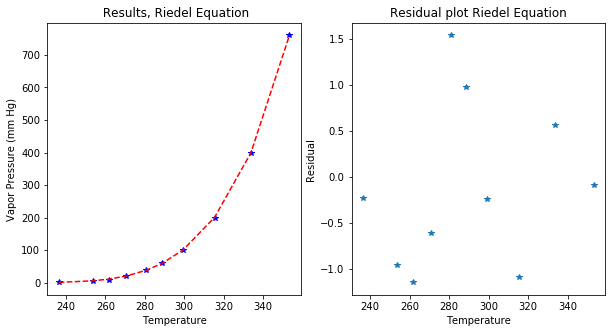

Residual variance: 1.26

          Beta       CI +/-
0   198.754691   135.399444
1 -8506.123235  4616.932359
2   -69.571242    49.702099
3     0.000044     0.000035


In [17]:
Yfit = riedel(x,*fit)
residuals = y-riedel(x,*fit)
dof = xyData.shape[0]-fit.shape[0]
tval = t.ppf(1-alpha/2,dof)
sigma = np.sqrt(np.diag(cov))
variance=np.dot(residuals.T,residuals)/dof
results = pd.DataFrame({'Beta':fit,
                        'CI +/-':sigma*tval})

plt.figure(figsize=(10,5))    

plt.subplot(1,2,1)
plt.title(' Results, Riedel Equation')
plt.plot(x,y,'b*')
plt.plot(x,Yfit,'r--')
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2)    
plt.title('Residual plot Riedel Equation')
plt.plot(x,residuals,'*')
plt.xlabel(x_name)
plt.ylabel('Residual')
plt.show()
print('Residual variance: {:3.2f}\n'.format(variance))
print(results)

The Riedel equation fits much better than the Clapeyron equation, but requires more parameters to do the fitting.

# Steady state material balances on a separation train (Problem 1-5)


The solve steady state material balances, written in a linear algebra form:

$$\begin{bmatrix}0.07 & 0.18 & 0.15&0.24\\0.04&0.24&0.1&0.65\\0.54&0.42&0.54&0.1\\0.35&0.16&0.21&0.01\end{bmatrix} \begin{bmatrix}D1\\B1\\D2\\B2\end{bmatrix}=70\begin{bmatrix}0.15\\0.25\\0.4\\0.2\end{bmatrix}$$


### Part a: 
Solve system of equations to find molar flowrates for $D1,B1,D2,B2$ :

In [18]:
A = np.matrix([[0.07,0.18,0.15,0.24],[0.04,0.24,0.1,0.65],
   [0.54,0.42,0.54,0.1],[0.35,0.16,0.21,0.01]])
b = np.array([0.15*70, 0.25*70, 0.4*70, 0.2*70])
x = np.linalg.solve(A,b)
print('Solution: D1={:3.2f}, B1={:3.2f}, D2={:3.2f}, B2={:3.2f}'.format(*x))

Solution: D1=26.25, B1=17.50, D2=8.75, B2=17.50


### Part b:
Do a brute force sensitivity analysis by applying a at 1 or 2% reduction to stream composition: 

In [19]:
for ix, label in enumerate(['Xylene','Styrene']):
    b_1 = b.copy()  # a peculiar twist with python... if you want to copy a variable, be sure to .copy()!
    b_1[ix] *= 0.99;
    print('The solution with one % reduction of {} is:'.format(label))
    x_1 = np.linalg.solve(A,b_1)
    print('D1={:3.2f}, B1={:3.2f}, D2={:3.2f}, B2={:3.2f}\n'.format(*x_1));          
    b_2 = b.copy()
    b_2[ix] *=0.98;
    print('The solution with two % reduction of {} is:'.format(label))
    x_2 = np.linalg.solve(A,b_2)
    print('D1={:3.2f}, B1={:3.2f}, D2={:3.2f}, B2={:3.2f}\n'.format(*x_2));  

The solution with one % reduction of Xylene is:
D1=26.55, B1=7.59, D2=15.68, B2=20.07

The solution with two % reduction of Xylene is:
D1=26.84, B1=-2.32, D2=22.62, B2=22.65

The solution with one % reduction of Styrene is:
D1=26.04, B1=22.72, D2=5.21, B2=15.86

The solution with two % reduction of Styrene is:
D1=25.82, B1=27.94, D2=1.66, B2=14.22



### Part c: 
Caluclate composition of $B$ and $D$ streams using compositions of $D1,B1,D2,B2$ :

In [20]:
D1 = x[0]
B1 = x[1]
D = D1+B1
x_Dx = (0.07*D1+0.18*B1)/D
x_Ds = (0.04*D1+0.24*B1)/D
x_Dt = (0.54*D1+0.42*B1)/D
x_Db = (0.35*D1+0.16*B1)/D

print('Calculations for D: \nXylene: {:1.3f}\nStyrene: {:1.3f}\nToluene: {:1.3f}\nBenzene: {:1.3f}\n'.format(x_Dx,x_Ds,x_Dt,x_Db))

D2 = x[2];
B2 = x[3];
B = D2+B2
x_Bx = (0.15*D2+0.24*B2)/B
x_Bs = (0.1*D2+0.65*B2)/B
x_Bt = (0.54*D2+0.10*B2)/B
x_Bb = (0.21*D2+0.01*B2)/B

print('Calculations for B: \nXylene: {:1.3f}\nStyrene: {:1.3f}\nToluene: {:1.3f}\nBenzene: {:1.3f}\n'.format(x_Bx,x_Bs,x_Bt,x_Bb))

Calculations for D: 
Xylene: 0.114
Styrene: 0.120
Toluene: 0.492
Benzene: 0.274

Calculations for B: 
Xylene: 0.210
Styrene: 0.467
Toluene: 0.247
Benzene: 0.077



# Gas Volume Calculations from Various Equations of State - Ideal gas (Problem 1-8a)

Using the ideal gas equation $PV=RT$, solve for gas molar volume $V$ given $P$, $R$, and $T$.  One way to solve this problem is to use a good non-linear solver like `curve_fit`, but for this solution, we'll take advantage of the symbolic math library `sympy`.  First, import the library:

In [21]:
from sympy.solvers import solve
from sympy import symbols
from sympy import init_printing  # to turn on nice-looking equations
init_printing()

Then define the equation to solve, using the `sympy` convention that all terms are collected on one side, i.e. we solve $PV-RT=0$ for $V$:

In [22]:
P,V,R,T=symbols('P V R T') # a quick way to create sympy variables

solution = solve(P*V-R*T,V)
solution

There is one solution, select it using `[0]`, then substitute $R=0.08206$, $T=300$, $P=100$ to get $V$:

In [23]:
V=solution[0].subs([(R,0.08206),(T,300),(P,100)])
V

Display total number of moles:

In [24]:
print('nmoles = {:3.2f}'.format(2.5*1000/V))

nmoles = 10155.17


# Gas Volume Calculations from Various Equations of State - van der Waals equation (Problem 1-8b)
Using the van der Waals equation $\left(P+\frac{a}{V^2}\right)\left(V-b\right)=RT$, solve for gas molar volume $V$ given $P$, $R$, and $T$.  Like with Problem 1-8a, utilize a symbolic solver to find the value of $V$.  


Like the previous example, we will define the symbolic variables and then solve the equation:

$$\left(P+\frac{a}{V^2}\right)\left(V-b\right)-RT=0$$


In [25]:
P,T,V,R,a,b=symbols('P T V R a b') # a quick way to create sympy variables

solutions = solve((P+a/(V**2))*(V-b)-R*T,V)
print('Number of solutions: {}'.format(len(solutions)))

Number of solutions: 3


From the symbolic math solver, there are three solutions.  First relate $a$ and $b$ as to critical temperature and critical pressure:

$$a=\frac{27}{64}\frac{R^2T_C^2}{P_C}$$

$$b=\frac{RT_C}{8P_C}$$

For each of the three solutions, substitue these values for the constants:

$$R=0.08206$$

$$Tc=304.2$$

$$Pc=72.9$$

$$T=300$$

$$P=100$$


In [26]:
Tc = 304.2
Pc = 72.9
for soln in solutions:
    print(soln.subs([(T,300),(P,100),(a,27*(R**2*Tc**2/Pc)/64),(b,R*Tc/(8*Pc)),(R,0.08206)]))

0.0795717110889382
0.127028446221984 + 0.0446457022983378/(-1/2 - sqrt(3)*I/2) + 0.0307008124771278*sqrt(3)*I
0.127028446221984 - 0.0307008124771278*sqrt(3)*I + 0.0446457022983378/(-1/2 + sqrt(3)*I/2)


In the list of the three solutions, only one is not complex, this value (0.07957) is the correct solution.


# Bubble Point Calculation for an Ideal Binary Mixture (Problem 1-9)

This example calculates the Bubble point temperature $T_{bp}$ for an ideal binary mixture.  Vapor pressure for each compound is described by the Antoine equation:

$$\log_{10}(P_{vap})=A-\frac{B}{T+C}$$

Where $A$, $B$, and $C$ are compound specific constants.  We could use `sympy` again to solve this problem algebraically, but lets instead use the `root` function from `scipy` to find the root iteratively.  First define an objective function defining the mole fraction of species A and using the equation for vapor pressure and vapor mole fraction as a function of $T_{bp}$:

In [27]:
def fun1_9(Tbp):
    xA = 0.1
    PA = 10**(6.85221-1064.63/(Tbp+232))
    PB = 10**(6.87776-1171.53/(224.366+Tbp))
    xB = 1-xA
    yA = xA*PA/760
    yB = xB*PB/760
    f = xA*PA+xB*PB-760
    return(f)
 
xguess=100;
print('Problem 1-9. Objective function at the initial estimate (Tbp= {:3.2f}): {:3.2f}'.format(xguess,fun1_9(xguess)))
xsolv=root(fun1_9,xguess); #Use fsolve  to solve the equation/s
print('Problem 1-9. Objective function at the solution (Tbp= {:3.2f}): {:3.2f}'.format(xsolv.x[0],fun1_9(xsolv.x[0])))


Problem 1-9. Objective function at the initial estimate (Tbp= 100.00): 1342.61
Problem 1-9. Objective function at the solution (Tbp= 63.66): 0.00


# Adiabatic Flame Temperature for Natural Gas Combustion (Problem 1-12)

Calculate the adiabatic flame temperature $T_ad$ that satisfies the equations:

$$H_f = H_0+212798yx+372820zx$$

$$H_f = \alpha T_{ad}+0.001\beta\frac{T_{ad}^2}{2}+10^{-6}\gamma\frac{T_{ad}^3}{3}$$

Where $x,y,z,\alpha,\beta,\gamma$ are known parameters.  To solve this cubic equation, use `scipy`'s `root` function.  First define the objective function:

In [28]:
def fun1_12(T):
    y = 0.75;
    x = 0.5;
    z = 1-y-0.02;
    if x<1:
        CH4 = y*(1-x);
        C2H6 =z*(1-x);
        CO2 =(y+2*z)*x;
        H2O =(2*y+3*z)*x;
        N2 = 0.02+3.76*(2*y+7*z/2)*x;
        O2 =0;
        xx=x;
    else:
        CH4 =0;
        C2H6 =0;
        CO2 =(y+2*z);
        H2O =(2*y+3*z);
        N2 = 0.02+3.76*(2*y+7*z/2)*x
        O2 = (2 * y + 7 * z / 2) * (x - 1)
        xx=1;

    alp = 3.381 * CH4 + 2.247 * C2H6 + 6.214 * CO2 + 7.256 * H2O + 6.524 * N2 + 6.148 * O2;
    bet = 18.044 * CH4 + 38.201 * C2H6 + 10.396 * CO2 + 2.298 * H2O + 1.25 * N2 + 3.102 * O2;
    gam = -4.3 * CH4 - 11.049 * C2H6 - 3.545 * CO2 + 0.283 * H2O - 0.001 * N2 - 0.923 * O2;
    H0 = alp * 298 + bet * 0.001 * 298 * 298 / 2 + gam * 1e-6 * 298 ** 3 / 3;
    Hf = alp * T + bet * 0.001 * T ** 2 / 2 + gam * 1e-6 * T ** 3 / 3
    f = 212798*y*xx+372820*z*xx+H0-Hf
    return(f)

Next, use an initial guess and calculate $T_{ad}$

In [29]:
xguess=1000
print('Problem 1-12. Objective function at the initial estimate (Tad= {:3.2f}): {:3.2f}'.format(xguess,fun1_12(xguess)))
xsolv=root(fun1_12,xguess); #Use fsolve  to solve the equation/s
print('Problem 1-12. Objective function at the solution (Tad= {:3.2f}): {:3.2f}'.format(xsolv.x[0],fun1_12(xsolv.x[0])))

Problem 1-12. Objective function at the initial estimate (Tad= 1000.00): 83404.39
Problem 1-12. Objective function at the solution (Tad= 2197.99): 0.00


The final value of $T_{ad} = 2198^{\circ} K$ seems reasonable and is a valid solution for the objective function

# Unsteady State Mixing in a Tank (Problem 1-13)

This problem examines a salt-containing stream mixing into in a stirred tank.  To determine the tank composition as a function of time, these differential equations must be solved:

$$\frac{dM}{dt}=10$$
$$\frac{dS}{dt}=2-10\frac{S}{M}$$

Where at $t=0$, $M=1000$ and $S=200$  Solving differential equations in Python is easy, using `scipy`'s `integrate` functionality.  Like in Matlab, first define a function that calculates $\frac{dM}{dt}$ and $\frac{dS}{dt}$ given $M$ and $S$:


In [30]:
# import integration functionality
from scipy import integrate

# define function to calculate derivative
def dydt1_13(y,t):
    M=y[0]
    S=y[1]
    dydt=[10,2-10*S/M]
    return(dydt)

Next, define the range of timepoints to consider, and then solve the ODEs:

In [31]:
tstart=0
tfinal=60
trange=np.linspace(tstart,tfinal,num=50)
y0=[1000, 200]

# solve the ODEs:
Y = integrate.odeint(dydt1_13, y0,trange)                                                              

Collect and display results at the start and end times of the inegration:

In [32]:
results =[]
results.append({'Time':tstart,'M':y0[0],'S':y0[1],
                'SaltPC':100*y0[1]/y0[0],
                'dMdt':dydt1_13(y0,tstart)[0],
                'dSdt':dydt1_13(y0,tstart)[1]})
results.append({'Time':tfinal,'M':y0[0],'S':y0[1],
                'SaltPC':100*y0[1]/y0[0],
                'dMdt':dydt1_13(Y[-1],tstart)[0],
                'dSdt':dydt1_13(Y[-1],tfinal)[1]})
pd.DataFrame(results,index=['Initial','Final'])

,M,S,SaltPC,Time,dMdt,dSdt
Initial,1000,200,20.0,0,10,0.000000
Final,1000,200,20.0,60,10,0.609375


Plot the total amount and % of salt over time:

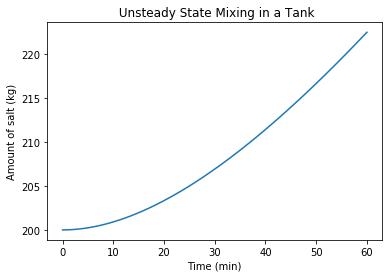

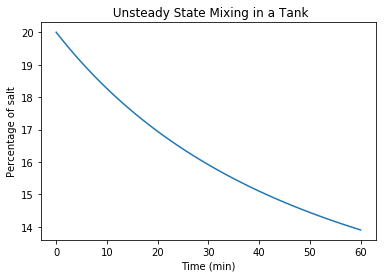

In [33]:
plt.figure()
plt.plot(trange,Y[:,1])
plt.title(' Unsteady State Mixing in a Tank')
plt.xlabel('Time (min)');
plt.ylabel('Amount of salt (kg)');

plt.figure()
SaltPC=100*Y[:,1]/Y[:,0];
plt.plot(trange,SaltPC);
plt.title(' Unsteady State Mixing in a Tank')
plt.xlabel('Time (min)');
plt.ylabel('Percentage of salt');

# Heat Exchange in a Series of Tanks (Problem 1-15a)

Here we model three identical well mixed tanks that are connected in series.  We wish to model the temperature trends at start up with when each tank is heated identically.  The differential equations to solve are:

$$\frac{dT_1}{dt}=\frac{WC_P\left(T_0-T_1\right)+UA\left(T_{steam}-T_1\right)}{MC_P}$$

$$\frac{dT_2}{dt}=\frac{WC_P\left(T_1-T_2\right)+UA\left(T_{steam}-T_2\right)}{MC_P}$$

$$\frac{dT_3}{dt}=\frac{WC_P\left(T_2-T_3\right)+UA\left(T_{steam}-T_3\right)}{MC_P}$$

Where at $t=0$, $T_0=T_1=T_2=T_3=20$

Held constant are tank volume  $M=1000$, flowrate $W=200$ liquid heat capacity $C_P=2$, Heat transfer coefficient $UA=10$ and jacket temperature $T_{steam}=250$  Like the last example, first define the problem:



In [34]:
# define constants- these will be available to the dydt function:
W=100
Cp=2.0
T0=20
UA=10
Tsteam=250
M=1000

def dydt1_15a(y,t):
    T1=y[0]
    T2=y[1]
    T3=y[2]
    dydt=[(W*Cp*(T0-T1)+UA*(Tsteam-T1))/(M*Cp),
    (W*Cp*(T1-T2)+UA*(Tsteam-T2))/(M*Cp),
    (W*Cp*(T2-T3)+UA*(Tsteam-T3))/(M*Cp)]
    return(dydt)

Then solve the problem:

In [35]:
tstart=0;
tfinal=200;
trange = np.linspace(tstart,tfinal,num=50)
y0=[20, 20, 20]
Y=integrate.odeint(dydt1_15a,y0,trange)

Print out conditions at the initial and final timepoints:

In [36]:
results =[]
results.append({'Time':tstart,'T1':y0[0],'T2':y0[1],'T3':y0[2],
                'W':W,'T0':T0,'UA':UA,'M':M,'Tsteam':Tsteam,'Cp':Cp,
                'dT1dt':dydt1_15a(y0,tstart)[0],
                'dT2dt':dydt1_15a(y0,tstart)[1],
                'dT3dt':dydt1_15a(y0,tstart)[2]})
results.append({'Time':tfinal,'T1':Y[-1,0],'T2':Y[-1,1],'T3':Y[-1,2],
                'W':W,'T0':T0,'UA':UA,'M':M,'Tsteam':Tsteam,'Cp':Cp,
                'dT1dt':dydt1_15a(Y[-1],tfinal)[0],
                'dT2dt':dydt1_15a(Y[-1],tfinal)[1],
                'dT3dt':dydt1_15a(Y[-1],tfinal)[2]})
pd.DataFrame(results,index=['Initial','Final'])

,Cp,M,T0,T1,T2,T3,Time,Tsteam,UA,W,dT1dt,dT2dt,dT3dt
Initial,2.0,1000,20,20.000000,20.00000,20.00000,0,250,10,100,1.150000e+00,1.150000e+00,1.150000e+00
Final,2.0,1000,20,30.952381,41.38322,51.31735,200,250,10,100,8.570971e-10,1.813058e-08,1.916444e-07


Plot the trends over time:

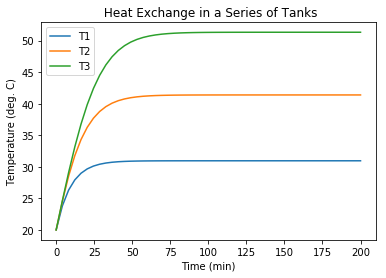

In [37]:
plt.plot(trange,Y);
plt.title(' Heat Exchange in a Series of Tanks')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (deg. C)')
plt.legend(['T1','T2','T3'],loc='best')

From the trends, it appears that the tanks reach a steady state after about an hour

# Conclusion
Python has been used here to solve some of the classic problems present in chemical engineering: linear regression, non-linear regression, and differential equations.  Its easy to get data into and results out of Python via the `pandas` and `matplotlib` modules.  Sharing portable reproducible work: inputs, code, and results is super simple when using a Jupyter notebook.  Beyond chemical engineering problem solving, Python is a great tool to learn for anyone working with multiple files, web sites, and untidy data looking to maximize their productivity.